## CE-like background: second pass

Scale up using Skeleton processor class

Dataset: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root`

First file: `nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root`

File lists: `/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.*.txt`

## Imports

A bit awkard but I'm using my dev version of pyutils 

In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import hist
import os
import json

import sys
sys.path.append("/home/sgrant/pyutils-dev/EventNtuple/utils/pyutils")

from pyprocess import Processor, Skeleton
from pyplot import Plot
from pyprint import Print
from pyselect import Select
from pyvector import Vector
from cut_manager import CutManager

In [2]:
# Need to think about the class structure here 
# It's mostly about naming conventions to be honest 
# I want import_dataset to be called process_dataset, but then that makes it sound like it should be in processor, which complicates things quite a bi
# I guess we could merge Importer and Processor? 
# How would this handle the single file case?
# process_file which would either get the array or do some custom some processing 
# process_dataset which would either parallelise getting the array 
# need to think about whether it's worth it 

# Define analysis methods 

In [3]:
class Analyse:
    """Class to handle analysis functions
    
    This class encapsulates all the analysis-specific logic,
    allowing it to be reused across different processors.
    """
    
    def __init__(self, verbosity=1):
        """Initialise the analysis handler
        
        Args:
            verbosity (int, optional): Level of output detail (0: minimal, 1: normal, 2: detailed)
        """
        self.verbosity = verbosity
        self.print_prefix = "[Analyse] "
        
        # Initialise tools
        self.selector = Select(verbosity=self.verbosity)
        self.vector = Vector(verbosity=self.verbosity) 
        
        # Analysis configuration
        self.on_spill = False  # Default to off-spill analysis
        
        print(f"{self.print_prefix}Initialised")

    # Can't we use lazy initialisation or something? 
    # # I guess we want to make sure each instance is seperate, but this feels off
    # def create_cut_manager(self):
    #     """Create a new CutManager instance
        
    #     Args:
    #         verbosity (int, optional): Verbosity level for the cut manager
        
    #     Returns:
    #         CutManager: A new cut manager instance
    #     """
    #     return CutManager(verbosity=self.verbosity)
    
    def define_cuts(self, data, cut_manager, on_spill=None):
        """Define analysis cuts
        
        Args:
            data: The data to apply cuts to
            cut_manager: The CutManager instance to use
            on_spill (bool, optional): Whether to apply on-spill specific cuts
            
        Returns:
            tuple: (modified data with additional fields, cut_manager with cuts defined)
        """
        if on_spill is None:
            on_spill = self.on_spill
            
        selector = self.selector
        
        # Tracker surfaces
        trk_front = selector.select_surface(data["trkfit"], sid=0)
        trk_mid = selector.select_surface(data["trkfit"], sid=1)
        trk_back = selector.select_surface(data["trkfit"], sid=2)
        in_trk = (trk_front | trk_mid | trk_back)
        
        # 1. Truth track parent is electron 
        is_electron = data["trkmc"]["trkmcsim"]["pdg"] == 11
        is_trk_parent = data["trkmc"]["trkmcsim"]["nhits"] == ak.max(data["trkmc"]["trkmcsim"]["nhits"], axis=-1)
        is_trk_parent_electron = is_electron & is_trk_parent 
        has_trk_parent_electron = ak.any(is_trk_parent_electron, axis=-1) # Any tracks with electron parents?
    
        cut_manager.add_cut(
            name="is_truth_electron", 
            description="Track parents are electrons (truth PID)", 
            mask=has_trk_parent_electron # has_trk_parent_electron
        )

        # 1.5 Also include trk.pdg == 11
        is_trk_electron = selector.is_electron(data["trk"])
    
        cut_manager.add_cut(
            name="is_reco_electron", 
            description="Tracks are assumed to be electrons (trk)", 
            mask=is_trk_electron # has_trk_parent_electron
        )
        
        # 2. Downstream tracks only through tracker
        is_downstream = selector.is_downstream(data["trkfit"])
    
         # trkseg-level definition, useful for plotting
        data["is_downstream_in_trk"] = is_downstream & trk_front 
    
        # trk-level definition (the actual cut)
        is_downstream = ak.all(~in_trk | is_downstream, axis=-1)
        cut_manager.add_cut(
            name="is_downstream",
            description="Downstream tracks only (p_z > 0 through tracker)",
            mask=is_downstream
        )
        
        # 3. Minimum hits
        has_hits = selector.has_n_hits(data["trk"], nhits=20)
        cut_manager.add_cut(
            name="has_hits",
            description="Minimum of 20 active hits in the tracker",
            mask=has_hits
        )
    
        if on_spill:
            # 4. Time at tracker entrance (trk level)
            within_t0 = ((640 < data["trkfit"]["trksegs"]["time"]) & 
                         (data["trkfit"]["trksegs"]["time"] < 1650))
        
            # trk-level definition (the actual cut)
            within_t0 = ak.all(~trk_front | within_t0, axis=-1)
            cut_manager.add_cut( # trk-level
                name="within_t0",
                description="t0 at tracker entrance (640 < t_0 < 1650 ns)",
                mask=within_t0
            )
            
        # 5. Track quality
        good_trkqual = selector.select_trkqual(data["trk"], quality=0.8)
        cut_manager.add_cut(
            name="good_trkqual",
            description="Track quality (quality > 0.8)",
            mask=good_trkqual
        )
        
        # 6. Loop helix maximum radius
        within_lhr_max = ((450 < data["trkfit"]["trksegpars_lh"]["maxr"]) & 
                          (data["trkfit"]["trksegpars_lh"]["maxr"] < 680)) # changed from 650
    
        # trk-level definition (the actual cut)
        within_lhr_max = ak.all(~trk_front | within_lhr_max, axis=-1)
        cut_manager.add_cut(
            name="within_lhr_max",
            description="Loop helix maximum radius (450 < R_max < 680 mm)",
            mask=within_lhr_max
        )
    
        
        # 7. Distance from origin
        within_d0 = (data["trkfit"]["trksegpars_lh"]["d0"] < 100)
    
        # trk-level definition (the actual cut)
        within_d0 = ak.all(~trk_front | within_d0, axis=-1) 
        cut_manager.add_cut(
            name="within_d0",
            description="Extrapolated position (d_0 < 100 mm)",
            mask=within_d0
        )
        
        # 8. Pitch angle
        within_pitch_angle = ((0.5577350 < data["trkfit"]["trksegpars_lh"]["tanDip"]) & 
                              (data["trkfit"]["trksegpars_lh"]["tanDip"] < 1.0))
    
        # trk-level definition (the actual cut) 
        within_pitch_angle = ak.all(~trk_front | within_pitch_angle, axis=-1)
        cut_manager.add_cut(
            name="within_pitch_angle",
            description="Extrapolated pitch angle (0.5577350 < tan(theta_Dip) < 1.0)",
            mask=within_pitch_angle
        )
    
        # 9. CRV veto: |dt| < 150 ns (dt = coinc time - track t0) 
        dt_threshold = 150  
    
        # Get min and max track t0 times for each event
        min_trk_time = ak.min(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)
        max_trk_time = ak.max(data["trkfit"]["trksegs"]["time"][trk_front], axis=-1)
    
        # Get min and max coincidence times for each event
        min_coinc_time = ak.min(data["crv"]["crvcoincs.time"], axis=-1)
        max_coinc_time = ak.max(data["crv"]["crvcoincs.time"], axis=-1)
    
        # Broadcast coincidence times to match track times structure
        # This requires creating a cartesian product between coinc times and track times
        # We'll use the ak.cartesian function to do this
        
        # First, create arrays with the right structure
        coinc_info = ak.zip({
            "min_time": min_coinc_time,
            "max_time": max_coinc_time
        })
        
        trk_info = ak.zip({
            "min_time": min_trk_time,
            "max_time": max_trk_time
        })
        
        # Use cartesian product to align each coinc with each track
        matched = ak.cartesian({"coinc": coinc_info, "track": trk_info})
        
        # Check if dt if within threshold
        veto = (
            (abs(matched["coinc", "min_time"] - matched["track", "max_time"]) < dt_threshold) & 
            (abs(matched["track", "min_time"] - matched["coinc", "max_time"]) < dt_threshold)
        )

        # Mark unvetoed events
        data["unvetoed"] = ~veto
        
        cut_manager.add_cut(
            name="unvetoed",
            description="No veto: |dt| >= 150 ns",
            mask=~veto,
            active=False
        )
        
        # Return the modified data and cut manager
        # return data, cut_manager

    def apply_cuts(self, data, cut_manager): 

        # Make a copy 
        # Not sure if needed, but preserves the original array
        data_cut = ak.copy(data)
        
        # Combine cuts
        combined = cut_manager.combine_cuts(active_only=False) 
        data_cut["combined"] = combined
        
        # # Select tracks
        data_cut["trk"] = data_cut["trk"][combined]
        data_cut["trkfit"] = data_cut["trkfit"][combined]
        data_cut["trkmc"] = data_cut["trkmc"][combined]
        
        # Then clean up events with no tracks after cuts
        combined = ak.any(combined, axis=-1)
        data_cut = data_cut[combined] 

        return data_cut
    
    def create_histograms(self, data, data_cut):
        """Create histograms from the data before and after applying cuts
        
        Args:
            data: Data before cuts
            data_cut: Data after cuts
            
        Returns:
            dict: Dictionary of histograms
        """
            
        # Histogram container 
        # histograms = {}

        # Tools 
        selector = self.selector 
        vector = self.vector

        try: 
            
            # Data
            at_trkent_all = selector.select_surface(data["trkfit"], sid=0)
            at_trkent_cut = selector.select_surface(data_cut["trkfit"], sid=0)
            
            mom_all = vector.get_mag(data["trkfit"]["trksegs"][at_trkent_all], "mom")
            mom_cut = vector.get_mag(data_cut["trkfit"]["trksegs"][at_trkent_cut], "mom")
        
            mom_all = ak.flatten(mom_all, axis=None)
            mom_cut = ak.flatten(mom_cut, axis=None)
    
            # Define histograms 
    
            # Create histogram objects to store the data
            # Full momentum range histogram
            hist_full_range = hist.Hist(
                hist.axis.Regular(250, 0, 250, name="momentum", label="Momentum [MeV/c]"),
                hist.axis.StrCategory(["All events", "CE-like events"], name="selection", label="Selection")
            )
            
            # Signal region histogram (fine binning)
            hist_signal_region = hist.Hist(
                hist.axis.Regular(13, 103.6, 104.9, name="momentum", label="Momentum [MeV/c]"),
                hist.axis.StrCategory(["All events", "CE-like events"], name="selection", label="Selection")
            )
            
            # Fill the histograms
    
            # Full range histogram
            hist_full_range.fill(momentum=mom_all, selection=np.full(len(mom_all), "All events"))
            hist_full_range.fill(momentum=mom_cut, selection=np.full(len(mom_cut), "CE-like events"))
            
            # Signal region histogram
            # For signal region, we need to filter the momenta to be within the range
            mom_all_sig = mom_all[(mom_all >= 103.6) & (mom_all <= 104.9)]
            mom_cut_sig = mom_cut[(mom_cut >= 103.6) & (mom_cut <= 104.9)]
            
            hist_signal_region.fill(momentum=mom_all_sig, selection=np.full(len(mom_all_sig), "All events"))
            hist_signal_region.fill(momentum=mom_cut_sig, selection=np.full(len(mom_cut_sig), "CE-like events"))
    
            return {
                "Wide range" : hist_full_range, 
                "Signal region": hist_signal_region
            }

        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error filling histograms: {e}")
            return None
        
    def execute(self, data, file_id):
        """Perform complete analysis on an array
        
        Args:
            data: The data to analyse
            file_id: Identifier for the file
            
        Returns:
            dict: Complete analysis results
        """
        # Create a fresh cut manager for this file

        cut_manager = CutManager(verbosity=self.verbosity)
        
        # Define cuts

        self.define_cuts(data, cut_manager)

        # Calculate cut stats

        cut_stats = cut_manager.calculate_cut_stats(data, progressive=True)
        # cut_manager.print_cut_stats(data, active_only=False)

        # Apply cuts

        data_cut = self.apply_cuts(data, cut_manager)
        
        # Create histograms

        histograms = self.create_histograms(data, data_cut)
        
        # Compile all results
        results = {
            "file_id": file_id,
            "cut_stats": cut_stats,
            "filtered_data": data_cut,
            "histograms": histograms,
        }
        
        return results

In [4]:
# Create your custom processor class
# We inherit from Skeleton - this gives us many pre-built methods without writing extra code
class MyProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        # self.defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt"
        self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_99.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_24.txt"
        # self.file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0.txt"
    
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True # Use remote file via mdh
        self.location = "disk" # File location
        self.max_workers = 100 # Limit the number of worker threads

        # Now add your own analysis-specific parameters 
        # # Histogram configuration: 1000 bins ranging from 0 to 10000
        # self.nbins = 1000         
        # self.xrange = (0, 10000)  

        # Analysis tools
        self.analyse = Analyse(verbosity=0)
            
        # Custom prefix for log messages from this processor
        self.print_prefix = "[MyProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create an Importer to extract data from this file
            # This uses the configuration parameters from our class
            
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0                     # Reduce output in worker threads
            )
            
            # Extract the data using the Importer
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(this_data, file_name)

            # Maybe results should be indexed dict instead with the file name?  
            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None

# ==========================================
# Create and run the processor
# ==========================================
# Create an instance of our custom processor
my_processor = MyProcessor()

# Run the processor on all files
# The execute method comes from the Skeleton parent class
results = my_processor.execute()

# At this point, 'hists' contains the results from all processed files
# You can now analyze, plot, or save these results

[Skeleton] ✅ Template initialised
[Analyse] Initialised
[MyProcessor] Initialised
[MyProcessor] Starting analysis
[pyutils] Setting environment variables for this process...
[pyutils] ✅ Environment variables set
[pyprocess] ✅ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=1
[pyprocess] ✅ Successfully loaded file list
	Path: /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.0_99.txt
	Count: 100 files
[pyprocess] Starting processing on 100 files with 100 workers


Processing: 100%|██████████████████████████████| 100/100 [02:52<00:00,  1.72s/file, succesful=100, f

[pyprocess] ✅ Returning 100 results
[MyProcessor] ✅ Analysis complete


In [5]:
# # print(results.keys()) 
# results[0]["cut_stats"]

In [8]:
# This should be in cut manager 

def combine_cut_stats(list_of_cut_stats):
    """Combine cut statistics from multiple files in the simplest way possible
    
    Args:
        list_of_cut_stats: List of cut statistics lists from different files
    
    Returns:
        list: Combined cut statistics
    """
    # Return empty list if no input
    if not list_of_cut_stats:
        return []
    
    # Use the first list as a template
    combined_stats = []
    for cut in list_of_cut_stats[0]:
        # Create a copy without the mask (which we don't need)
        cut_copy = {k: v for k, v in cut.items() if k != 'mask'}
        # Reset the event count
        cut_copy['events_passing'] = 0
        combined_stats.append(cut_copy)
    
    # Sum up events_passing for each cut across all files
    for file_stats in list_of_cut_stats:
        for i, cut in enumerate(file_stats):
            if i < len(combined_stats):  # Safety check
                combined_stats[i]['events_passing'] += cut['events_passing']
    
    # Recalculate percentages
    if combined_stats and combined_stats[0]['events_passing'] > 0:
        total_events = combined_stats[0]['events_passing']
        previous_events = total_events
        
        for i, cut in enumerate(combined_stats):
            events = cut['events_passing']
            
            # Absolute percentage
            cut['absolute_frac'] = (events / total_events) * 100.0
            
            # Relative percentage
            if i == 0:  # "No cuts"
                cut['relative_frac'] = 100.0
            else:
                prev_events = combined_stats[i-1]['events_passing']
                cut['relative_frac'] = (events / prev_events) * 100.0 if prev_events > 0 else 0.0
    
    return combined_stats

stats = []
for result in results:
    stats.append(result["cut_stats"])
    
combined_stats = combine_cut_stats(stats)
# cut_manager = CutManager()
# cut_manager.print_cut_stats(stats=combined_stats, active_only=False)
# print(combined_stats)
# print(stats[0])

In [10]:
# This should actually come from cut manager 

def print_cut_stats(data=None, stats=None, progressive=True, active_only=False):
    """ Print cut statistics for each cut.
    
    Args:
        data (awkward.Array): Data array
        progressive (bool, optional): If True, apply cuts progressively; if False, apply each cut independently
    """

    # Input validation
    sources = sum(x is not None for x in [data, stats]) 
    if sources != 1:
        print(f"{self.print_prefix} Please provide exactly one of 'data' or 'stats'") 
        return None

    if not stats:
        stats = calculate_cut_stats(data, progressive, active_only)
    
    # Print header
    # print(f"\n{self.print_prefix}Cut Info:")
    print("-" * 110)
    header = "{:<20} {:<10} {:<20} {:<20} {:<20} {:<30}".format(
        "Cut", "Active", "Events Passing", "Absolute Frac. [%]", "Relative Frac. [%]", "Description")
    print(header)
    print("-" * 110)
    
    # Print each cut's statistics
    for stat in stats:
        row = "{:<20} {:<10} {:<20} {:<20.2f} {:<20.2f} {:<30}".format(
            stat["name"], 
            stat["active"],
            stat["events_passing"], 
            stat["absolute_frac"], 
            stat["relative_frac"], 
            stat["description"])
        print(row)
        
    print("-" * 110)
    
    # Print final statistics
    if len(stats) > 1:
        first_events = stats[0]["events_passing"]
        last_events = stats[-1]["events_passing"]
        overall_eff = last_events / first_events * 100 if first_events > 0 else 0
        
        # print(f"{self.print_prefix}Summary: {last_events}/{first_events} events remaining ({overall_eff:.2f}%)")
        print(f"Summary: {last_events}/{first_events} events remaining ({overall_eff:.2f}%)")
        
print_cut_stats(stats=combined_stats, active_only=False)

--------------------------------------------------------------------------------------------------------------
Cut                  Active     Events Passing       Absolute Frac. [%]   Relative Frac. [%]   Description                   
--------------------------------------------------------------------------------------------------------------
No cuts              N/A        705770               100.00               100.00               No selection applied          
is_truth_electron    1          284890               40.37                40.37                Track parents are electrons (truth PID)
is_reco_electron     1          262343               37.17                92.09                Tracks are assumed to be electrons (trk)
is_downstream        1          187318               26.54                71.40                Downstream tracks only (p_z > 0 through tracker)
has_hits             1          159070               22.54                84.92                Minimum of 20 ac

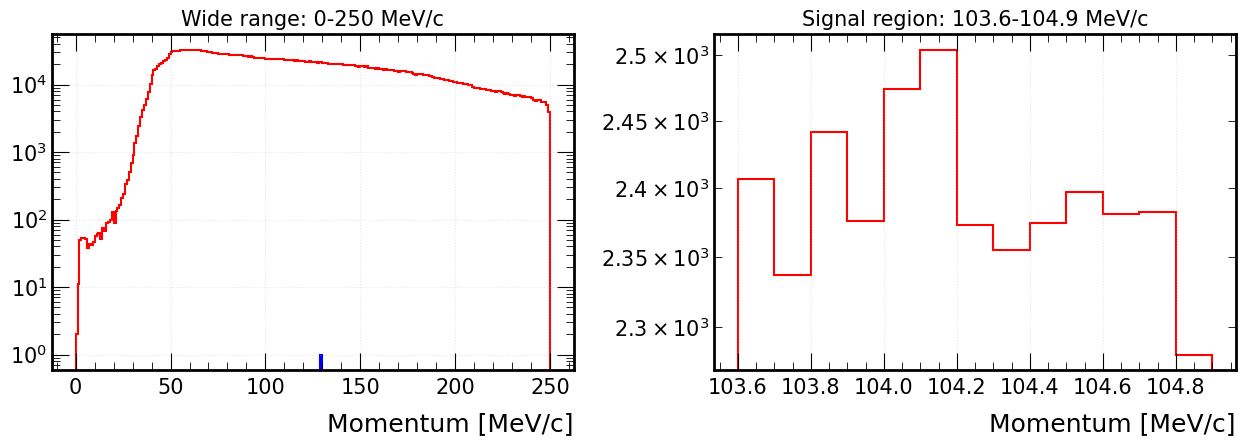

In [16]:
def combine_histograms(results):
    """Combine histograms from multiple files
    
    Args:
        file_results: Dictionary with file IDs as keys and results as values
                     Each result contains a 'histograms' dict
    
    Returns:
        dict: Combined histograms
    """
    combined_hists = {}
    
    # Check if we have results
    if not results:
        return None
    
    # Loop through all files
    for result in results: # 
        # Skip if no histograms in this file
        if 'histograms' not in result or not result['histograms']:
            continue
        
        # Process each histogram type
        for hist_name, hist_obj in result['histograms'].items():
            if hist_name not in combined_hists:
                # First time seeing this histogram type, initialise
                combined_hists[hist_name] = hist_obj.copy()
            else:
                # Add this histogram to the accumulated one
                combined_hists[hist_name] += hist_obj
    
    return combined_hists

# Usage example:
combined_histograms = combine_histograms(results)

# Now you can plot them
plt.style.use("/home/sgrant/pyutils-dev/EventNtuple/utils/pyutils/mu2e.mplstyle")
fig, axes = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

# Plot wide range in first subplot
if 'Wide range' in combined_histograms:
    h_wide = combined_histograms['Wide range']
    h_wide.plot1d(overlay='selection', ax=axes[0])
    axes[0].set_title("Wide range: 0-250 MeV/c")
    axes[0].set_yscale('log')
    axes[0].grid(True, alpha=0.3)

# Plot signal region in second subplot
if 'Signal region' in combined_histograms:
    h_signal = combined_histograms['Signal region']
    h_signal.plot1d(overlay='selection', ax=axes[1])
    axes[1].set_title("Signal region: 103.6-104.9 MeV/c")
    axes[1].set_yscale('log')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylabel("")  # Remove duplicate y-label

plt.tight_layout()
plt.savefig("combined_momentum_comparison.png", dpi=300)
plt.show()

In [22]:
# print(results[0])
data_cut = {} 
for result in results: 
    this_data_cut = result["filtered_data"]
    if len(this_data_cut) == 0: 
        continue

    print(result["file_id"])
    
    if len(data_cut) == 0: 
        data_cut = this_data_cut
    else: 
        this_data_cut = ak.concatenate(data_cut)
        print(result["file_id"])

printer = Print()
printer.print_n_events(data_cut, n_events=10)

nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00015002.root
[pyprint] Initialised Print with verbose = False and precision = 1

[pyprint] ---> Printing 10 event(s)...

-------------------------------------------------------------------------------------
evt.event: 283508
evt.run: 1202
evt.subrun: 17940
crv.crvcoincs.time: [2.44e+04, 2.44e+04, 2.43e+04]
crv.crvcoincs.nHits: [16, 33, 13]
is_downstream_in_trk: [[False, False, False, False, False, ..., False, True, False, False], ...]
unvetoed: [True, True, True, True]
combined: [True, False, False, False]
trk.trk.pdg: [11]
trk.trk.nactive: [37]
trk.trkqual.valid: [True]
trk.trkqual.result: [0.957]
trkfit.trksegs.mom.fCoordinates.fX: [[90.7, 102, 104, 104, -54.2, 40.8, 54.4, -8.52, -78.8, -55.3]]
trkfit.trksegs.mom.fCoordinates.fY: [[-73.9, -17.7, -5.79, 6.31, 86.4, -83.3, 75.2, -85.2, -32.4, 63.4]]
trkfit.trksegs.mom.fCoordinates.fZ: [[55.4, 77.1, 77, 76.9, 79.5, 90.2, 90, 96.6, 96.7, 97.2]]
trkfit.t